In [63]:
import numpy as np
from numpy.linalg import svd
import scipy.signal as sig
from scipy.fft import fft, ifft
import IPython.display as ipd
import cv2
import librosa 
import pandas as pd

from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# SELECCIÓN DE AUDIO

In [2]:
def select_files(b):
    clear_output()
    root = Tk()
    root.withdraw() 
    root.call('wm', 'attributes', '.', '-topmost', True) 
    b.files = filedialog.askopenfilename(multiple=False)  

In [3]:
# creacion de un boton para cargar un archivo de audio
boton1_audio = Button(description="Archivo 1")
boton1_audio.on_click(select_files)
boton2_audio = Button(description="Archivo 2")
boton2_audio.on_click(select_files)
print("Seleccione un archivo de audio .wav")
display(boton1_audio,boton2_audio)

Seleccione un archivo de audio .wav


Button(description='Archivo 1', style=ButtonStyle())

Button(description='Archivo 2', style=ButtonStyle())

In [4]:
# Cargamos el archivo de audio 1 y reproducimos para corroborar
audio_data1, fs1 = librosa.load(boton1_audio.files,sr=None)
ipd.Audio(audio_data1, rate=fs1)

In [5]:
# Cargamos el archivo de audio 2 y reproducimos para corroborar
audio_data2, fs2 = librosa.load(boton2_audio.files,sr=None)
ipd.Audio(audio_data2, rate=fs2)

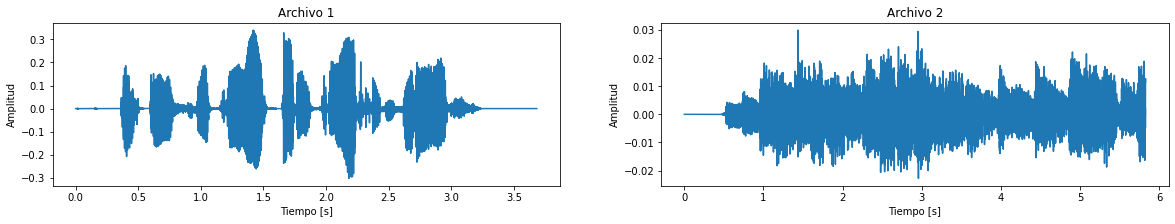

In [6]:
parameters = {"xtick.labelsize": 10, "ytick.labelsize": 10, "figure.figsize":(20,3),
             "axes.labelsize":10,"axes.titlesize":12}
plt.rcParams.update(parameters)
plt.subplot(1,2,1)
plt.plot(np.arange(0,len(audio_data1))/fs1,audio_data1)
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.title("Archivo 1")
plt.subplot(1,2,2)
plt.plot(np.arange(0,len(audio_data2))/fs2,audio_data2)
plt.ylabel('Amplitud')
plt.xlabel('Tiempo [s]')
plt.title("Archivo 2")
plt.tight_layout
plt.show()

# SELECCIÓN DE IMAGEN

In [9]:
# creacion de un boton para cargar una imagen
boton_img = Button(description="Seleccionar")
boton_img.on_click(select_files)
print("Seleccione una imagen")
display(boton_img)

Seleccione una imagen


Button(description='Seleccionar', style=ButtonStyle())

In [12]:
# Cargo los datos de la imagen
img= cv2.imread(boton_img.files)
# Paso la imagen a escala de grises
img_grey=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# Defino un valor de umbral para el paso a binario
umbral=100
# Paso la imagen a binario
img_bin=np.uint8((img_grey<umbral))


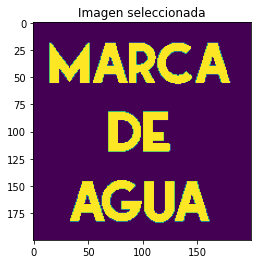

In [13]:
# Ploteo la imagen seleccionada
parameters = {"xtick.labelsize": 10, "ytick.labelsize": 10, "figure.figsize":(20,4),
             "axes.labelsize":10,"axes.titlesize":12}
plt.rcParams.update(parameters)
plt.title("Imagen seleccionada")
plt.imshow(img_bin,vmin=0,vmax=1)
plt.tight_layout
plt.show()

# EMBEDDING

## Calculo la STFT del audio

In [436]:
# Calculo la stft del audio
window = 'hann' # defino el tipo de ventana como hann
nperseg = np.round(0.025*fs1) # defino el largo de cada segmento temporal, en este caso 25 ms
noverlap = nperseg//2 #se solapan la mitad de las muestras de cada ventana temporal
nfft = nperseg # nefino el largo de cada ventana si es mayor que nperseg se realizara zero padding
return_onesided = False# Devuelve solo la mitad del espectro
# Calculo la STFT utilizando el modulo de scipy

# Calculo para el archivo 1
frec1,time1,stft_audio1 = sig.stft(audio_data1, fs1, window=window,nperseg=nperseg, nfft=nfft, noverlap=noverlap, return_onesided=return_onesided)
# Caclculo para el archivo 2
frec2,time2,stft_audio2 = sig.stft(audio_data2, fs2, window=window,nperseg=nperseg, nfft=nfft, noverlap=noverlap, return_onesided=return_onesided)

## Descomposicion en valores singulares

In [417]:
# Calculo la descomposicion en valores singulares para la matrix que contien el espectrograma del archivo 1
uh1, sh1, vth1=svd(stft_audio1,full_matrices=False)
# Calculo la descomposicion en valores singulares para la matrix que contien el espectrograma del archivo 2
uh2, sh2, vth2=svd(stft_audio2,full_matrices=False)
# Calculo la descomposicion en valores singulares para la matrix de la imagen
uw, sw, vtw=svd(img_bin,full_matrices=False)

## Generación de la nueva matriz con los valores de la marca de agua 

In [418]:
# Defino un valor de para el indioce de robustez alpha
alpha=0.001
def embedding(sh,sw,uh,vth,alpha):
    
    # Igulalo las dimensiones de los vectores para poder operar
    sw=np.append(sw,np.zeros(len(sh)-len(sw)))
    # Genero la matriz diagonal con los datos binarios de la imagen
    snw= sh+(sw*alpha)
    # Convierto el vector en una matriz diagonal para poder operar
    snw=np.diag(snw)
    # Calculo el producto de matrices utilizando numpy.dot
    Hw=np.dot(uh,snw)
    Hw=np.dot(Hw,vth)
    
    return Hw

In [419]:
Hw1=embedding(sh1,sw,uh1,vth1,alpha)
Hw2=embedding(sh2,sw,uh2,vth2,alpha)

## Transformada inversa ISTFT

In [420]:
# Calculo la transformada inversa para el audio 1
t1, audio1_watermarked=sig.istft(Hw1, fs1, nperseg=nperseg, window=window,nfft=nfft, noverlap=noverlap,input_onesided=False)
ipd.Audio(audio1_watermarked, rate=fs1)

C:\Users\TOBIAS\anaconda3\lib\site-packages\IPython\lib\display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [421]:
# Calculo la transformada inversa para el audio 2
t2, audio2_watermarked=sig.istft(Hw2, fs2, nperseg=nperseg, window=window,nfft=nfft, noverlap=noverlap,input_onesided=False)
ipd.Audio(audio2_watermarked, rate=fs2)

### Ataque 1 - Addicion de ruido Gaussiano
    Agregamos ruido de distribucion Gaussiana a el archivo de audio que posee la marca de agua, para luego ver como afecta este proceso a la imagen embebida

In [422]:
# Genero un ruido aleatorio con distribucion normal para sumar al archivo 1
noise1=np.random.normal(0,0.01,len(audio1_watermarked))
# Agrego el ruido a al archivo 1 con la marca de agua
audio1_watermarked_at1=audio1_watermarked+noise1


# Genero un ruido aleatorio con distribucion normal para sumar al archivo 2
noise2=np.random.normal(0,0.01,len(audio2_watermarked))
# Agrego el ruido a al archivo 2 con la marca de agua
audio2_watermarked_at1=audio2_watermarked+noise2


### Ataque 2 - Cropping, reemplazo de valores por 0
    Reemplazmos algunos segundos del archivo de audio que posee la marca de agua, para ver como esto afecta a la imagen embebida
   

In [423]:
# Cortmamos medio segundo del archivo de audio 1
t1=int(0.5*fs1)
audio1_watermarked_at2=np.copy(audio1_watermarked)
for i in range(t1):
    audio1_watermarked_at2[i]=0
# Cortmamos medio segundo del archivo de audio 2
t2=int(2*fs2)
audio2_watermarked_at2=np.copy(audio2_watermarked)
for i in range(t2):
    audio2_watermarked_at2[i]=0

# EXTRACCION DE LA MARCA DE AGUA

In [424]:
# Calculo de la STFT

# Para el audio 1 
frec1,time1,stft_audio1_w = sig.stft(audio1_watermarked, fs1, nperseg=nperseg, nfft=nfft, noverlap=noverlap, return_onesided=return_onesided)
# Para el audio 1 con el ataque1 
frec1_at1,time1_at1,stft_audio1_w_at1 = sig.stft(audio1_watermarked_at1, fs1, nperseg=nperseg, nfft=nfft, noverlap=noverlap, return_onesided=return_onesided)
# Para el audio 1 con el ataque 2
frec1,time1,stft_audio1_w_at2 = sig.stft(audio1_watermarked_at2, fs1, nperseg=nperseg, nfft=nfft, noverlap=noverlap, return_onesided=return_onesided)

# Para el audio 2 
frec2,time2,stft_audio2_w = sig.stft(audio2_watermarked, fs2, nperseg=nperseg, nfft=nfft, noverlap=noverlap, return_onesided=return_onesided)
# Para el audio 2 con el ruido ataque 1
frec2_at1,time2_at1,stft_audio2_w_at1 = sig.stft(audio2_watermarked_at1, fs2, nperseg=nperseg, nfft=nfft, noverlap=noverlap, return_onesided=return_onesided)
# Para el audio 2 con el ruido ataque 2
frec2,time2,stft_audio2_w_at2 = sig.stft(audio2_watermarked_at2, fs2, nperseg=nperseg, nfft=nfft, noverlap=noverlap, return_onesided=return_onesided)


In [425]:
# Calculo la descomposicion en valores singulares para la matrix que contien el espectrograma
# Para el archivo 1
uhw1, shw1, vthw1=svd(stft_audio1_w,full_matrices=False)
uhw1_at1, shw1_at1, vthw1_at1=svd(stft_audio1_w_at1,full_matrices=False)
uhw1_at2, shw1_at2, vthw1_at2=svd(stft_audio1_w_at2,full_matrices=False)
# Para el archivo 2
uhw2, shw2, vthw2=svd(stft_audio2_w,full_matrices=False)
uhw2_at1, shw2_at1, vthw2_at1=svd(stft_audio2_w_at1,full_matrices=False)
uhw2_at2, shw2_at2, vthw2_at2=svd(stft_audio2_w_at2,full_matrices=False)

In [426]:
# Defino una funcion que me permita extraer la marca de agua
def ext_watermark(shw,sh,alpha,uw,vtw):
    shw=np.diag(shw)
    #s_ext=(snw-shw)
    s_ext=shw-np.diag(sh)
    s_ext=s_ext/alpha

    #s_ext=np.diag(s_ext)
    s_ext=s_ext[0:200,0:200]
    #s_ext=np.diag(s_ext)

    # Aplico la inversa del SVD multiplicando las matrices
    img_w=np.dot(uw,s_ext)
    img_w=np.dot(img_w,vtw)
    return img_w

In [427]:
# Extraccion de las marcas de agua

# Para el archivo 1
img_audio1_w=np.round(ext_watermark(shw1,sh1,alpha,uw,vtw))
# Para el archivo 1 con la modificacion del ataque 1
img_audio1_w_at1=np.round(ext_watermark(shw1_at1,sh1,alpha,uw,vtw))
# Para el archivo 1 con la modificacion del ataque 2
img_audio1_w_at2=np.round(ext_watermark(shw1_at2,sh1,alpha,uw,vtw))

# Para el archivo 2
img_audio2_w=np.round(ext_watermark(shw2,sh2,alpha,uw,vtw))
# Para el archivo 2 con la modificacion del ataque 1
img_audio2_w_at1=np.round(ext_watermark(shw2_at1,sh2,alpha,uw,vtw))
# Para el archivo 1 con la modificacion del ataque 2
img_audio2_w_at2=np.round(ext_watermark(shw2_at2,sh2,alpha,uw,vtw))


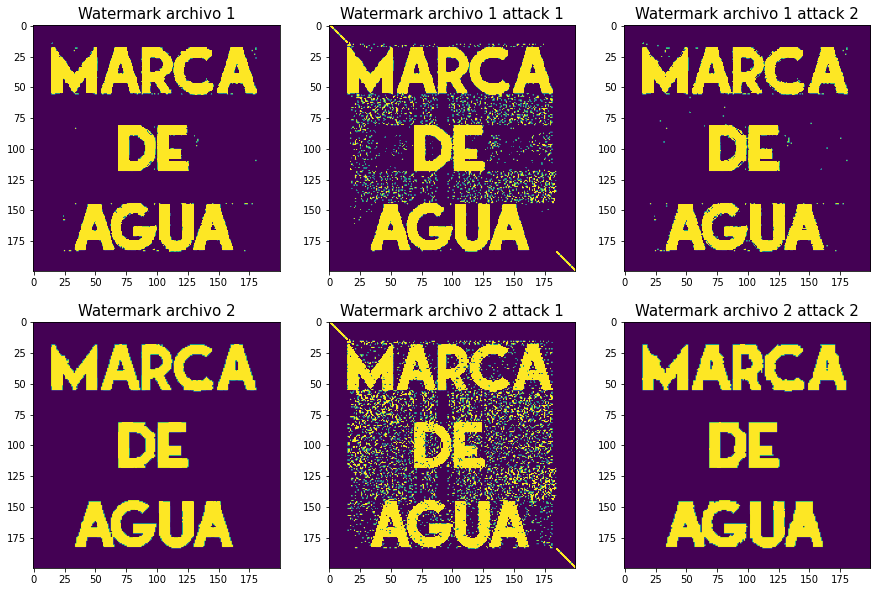

In [428]:
parameters = {"xtick.labelsize": 10, "ytick.labelsize": 10, "figure.figsize":(15,10),
             "axes.labelsize":10,"axes.titlesize":15}
plt.rcParams.update(parameters)

fig, axs=plt.subplots(2,3)

axs[0,0].set_title("Watermark archivo 1")
axs[0,0].imshow(img_audio1_w,vmax=1,vmin=0)

axs[0,1].set_title("Watermark archivo 1 attack 1")
axs[0,1].imshow(img_audio1_w_at1,vmax=1,vmin=0)

axs[0,2].set_title("Watermark archivo 1 attack 2")
axs[0,2].imshow(img_audio1_w_at2,vmax=1,vmin=0)

axs[1,0].set_title("Watermark archivo 2")
axs[1,0].imshow(img_audio2_w,vmax=1,vmin=0)

axs[1,1].set_title("Watermark archivo 2 attack 1")
axs[1,1].imshow(img_audio2_w_at1,vmax=1,vmin=0)

axs[1,2].set_title("Watermark archivo 2 attack 2")
axs[1,2].imshow(img_audio2_w_at2,vmax=1,vmin=0)

plt.show()

# EVALUCION DE ROBUSTEZ E IMPERCIPTIBILIDAD DEL PROCESO

### Peak-signal-noise-ratio (PSNR)

In [429]:
#Defino una funcion para el calulo del PSNR 
def PSNR(audio_org,audio_w):
# audio_org corresponde al audio original sin imagen embebida
# audio_w corresponde corresponde al audio con la marca de agua
    
    M=int(np.asarray(np.shape(audio_org[:,0]))) 
    N=int(np.asarray(np.shape(audio_org[0,:]))) 
# Calculo el error cuadratiaco medio entre la imagen original y la extraida de la marca de agua
    MSE=0
    for i in range(M) :
        for j in range(N) :
            MSE=MSE+(abs(audio_org[i,j])-abs(audio_w[i,j]))**2
    MSE=MSE/(M*N)

    PSNR=np.round((10*np.log10((np.max(abs(audio_org))**2)/MSE)),0)
    return PSNR

In [430]:
# Calculo el valor de PSNR para los distintos casos
# Audio 1
psnr_audio1=PSNR(stft_audio1,stft_audio1_w)
psnr_audio1_at1=PSNR(stft_audio1,stft_audio1_w_at1)
psnr_audio1_at2=PSNR(stft_audio1,stft_audio1_w_at2)
# Audio 2 
psnr_audio2=PSNR(stft_audio2,stft_audio2_w)
psnr_audio2_at1=PSNR(stft_audio2,stft_audio2_w_at1)
psnr_audio2_at2=PSNR(stft_audio2,stft_audio2_w_at2)

In [431]:
# Muestro los resultados en una tabla
tabla_PSNR = { "":["Audio 1", "Audio 2"], 'PSNR': [psnr_audio1,psnr_audio2], 'Attack 1 (PSNR %)': [psnr_audio1_at1/psnr_audio1,psnr_audio2_at1/psnr_audio2], 
                                                                            'Attack 2 (PSNR %)': [psnr_audio1_at2/psnr_audio1,psnr_audio2_at2/psnr_audio2]}
tabla_PSNR = pd.DataFrame(tabla_PSNR)
tabla_PSNR.loc[:]

,,PSNR,Attack 1 (PSNR %),Attack 2 (PSNR %)
0,Audio 1,37.0,0.972973,1.000000
1,Audio 2,28.0,0.785714,1.035714


### Normalized correlation (NC)

In [432]:
def NC(w,w_at):
    
# w a la marca de agua sin ningun ataque
# w_at corresponde a la marca de agua a la que se le realiza un attaque

    M=int(np.asarray(np.shape(w[0,:]))) # Numero filas de la imagen
    N=int(np.asarray(np.shape(w[:,0]))) # Numero de columnas de la imagen
    
    mu1=np.mean(w) # valor medio de la los valores de la imagen original
    mu2=np.mean(w_at) # valor medio de la los valores de la imagen extraida de la marca de agua
    # Genero variables auxiliares para el calculo
    num=0
    den1=0
    den2=0
    for i in range(M) :
        for j in range(N) :
            num=num+(w[i,j]-mu1)*(w_at[i,j]-mu2)
            den1=den1+(w[i,j]-mu1)**2
            den2=den2+(w_at[i,j]-mu2)**2
    NC=num/(np.sqrt(den1)*np.sqrt(den2))
    
    return NC
           

In [433]:
# Calculo el NC poara los distintos casos
# Audio 1
nc_audio1=NC(img_bin,img_audio1_w)
nc_audio1_at1=NC(img_bin,img_audio1_w_at1)
nc_audio1_at2=NC(img_bin,img_audio1_w_at2)
# Audio 2
nc_audio2=NC(img_bin,img_audio2_w)
nc_audio2_at1=NC(img_bin,img_audio2_w_at1)
nc_audio2_at2=NC(img_bin,img_audio2_w_at2)


In [434]:
tabla_NC = { "":["Audio 1", "Audio 2"],'NC': [nc_audio1,nc_audio2], 'NC Attack 1': [nc_audio1_at1,nc_audio2_at1], 'NC Attack 2': [nc_audio1_at2,nc_audio2_at2]}
tabla_NC = pd.DataFrame(tabla_NC)
tabla_NC.loc[:]

,,NC,NC Attack 1,NC Attack 2
0,Audio 1,0.90992,0.880929,0.888891
1,Audio 2,0.93423,0.612997,0.921377
